# Reaction analysis on heterogeneous catalysts

In the previous section, we learned how to use the NEB method to calculate activation energies using organic molecules as the example. <br/>
In this section, we will try to analyze the reaction of NO dissociation on the [heterogeneous catalyst](https://en.wikipedia.org/wiki/Heterogeneous_catalysis) Rh as a more practical application.

The workflow is as follows.<br/>
Create the Rh slab structure that will be the catalyst. <br/>
and adsorb the NO which is the reactant molecule. <br/>
Then, the states before and after the reaction are created and the activation energy is calculated using the NEB method.

Note that the content of this tutorial is based on the example published in matlantis-contrib.

 - [matlantis-contrib/matlantis_contrib_examples/NEB_Solid_catalyst](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/matlantis_contrib_examples/NEB_Solid_catalyst)


<a id="chap0"></a>

## Setup

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display_png
from IPython.display import Image as ImageWidget
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from PIL import Image, ImageDraw

import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v3.0.0")
calculator = ASECalculator(estimator)

<a id="chap1"></a>

## 1. Create slab from bulk structures

Rh is used as a catalyst in this example. <br/>
The slab structure can be created from the bulk structure.

### 1-1 Bulk structure loading

The cif file of the bulk structure is downloaded from Materials Project and saved into the input folder.

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

In [2]:
bulk = read("../input/Rh_mp-74_conventional_standard.cif")
print("Number of atoms =", len(bulk))
print("Initial lattice constant =", bulk.cell.cellpar())


bulk.calc = calculator
opt = LBFGS(ExpCellFilter(bulk))
opt.run()
print ("Optimized lattice constant =", bulk.cell.cellpar())

Number of atoms = 4
Initial lattice constant = [ 3.843898  3.843898  3.843898 90.       90.       90.      ]
       Step     Time          Energy          fmax
LBFGS:    0 14:51:03      -25.513043        3.630661
LBFGS:    1 14:51:03      -24.777766       14.187714


/tmp/ipykernel_38592/294556526.py:7: FutureWarning: Import ExpCellFilter from ase.filters
  opt = LBFGS(ExpCellFilter(bulk))


LBFGS:    2 14:51:03      -25.584262        0.758420
LBFGS:    3 14:51:03      -25.587143        0.147558
LBFGS:    4 14:51:03      -25.587264        0.001962
Optimized lattice constant = [ 3.79327332  3.79327361  3.79327344 89.99998864 90.00000054 90.00000144]


The [sort](https://wiki.fysik.dtu.dk/ase/ase/build/tools.html#ase.build.sort) method in ASE sorts the order of atoms according to the atomic number.

In [3]:
from pfcc_extras.visualize.view import view_ngl

bulk = bulk.repeat([2, 2, 2])
bulk = sort(bulk)
# Shift positions a bit to prevent surface to be cut at wrong place when `makesurface` is called
bulk.positions += [0.01, 0, 0]

view_ngl(bulk, representations=["ball+stick"])

### 1-2 Create slab structures

Create slab structures from bulk structures with any Miller index.
We can specify the `miller_indices=(x,y,z)`. The [surface](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#create-specific-non-common-surfaces) method is used in the `makesurface` to create a surface structure.

In [4]:
from ase import Atoms
from ase.build import surface


def makesurface(
    atoms: Atoms, miller_indices=(1, 1, 1), layers=4, rep=[4, 4, 1]
) -> Atoms:
    s1 = surface(atoms, miller_indices, layers)
    s1.center(vacuum=10.0, axis=2)
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0, 0, min(s1.get_positions()[:, 2])])
    s1.pbc = True
    return s1

In [5]:
slab = makesurface(bulk, miller_indices=(1, 1, 1), layers=2, rep=[1, 1, 1])
slab = sort(slab)
# adjust `positions` before `wrap`
slab.positions += [1, 1, 0]
slab.wrap()

view_ngl(slab, representations=["ball+stick"])

### 1-3 Check the z-coordinate of the created slab

Check the highest coordinates of the slab along the z axis (it is necessary when creating the adsorption structure). <br/>
Check the coordinates of each layer of the slab (it is necessary to determine how many layers to fix).

x         y             z symbol
0    1.007071  0.995918  4.019979e-08     Rh
1   10.394943  1.770216  2.190048e+00     Rh
2    6.371569  8.738904  2.190048e+00     Rh
3    2.348195  1.770216  2.190048e+00     Rh
4   14.418317  8.738904  2.190048e+00     Rh
..        ...       ...           ...    ...
59   5.030444  3.318814  6.570143e+00     Rh
60   1.007070  0.995918  6.570143e+00     Rh
61   5.030444  4.867411  4.380095e+00     Rh
62   6.371569  2.544515  4.380095e+00     Rh
63   7.712693  4.867411  4.380095e+00     Rh

[64 rows x 4 columns]

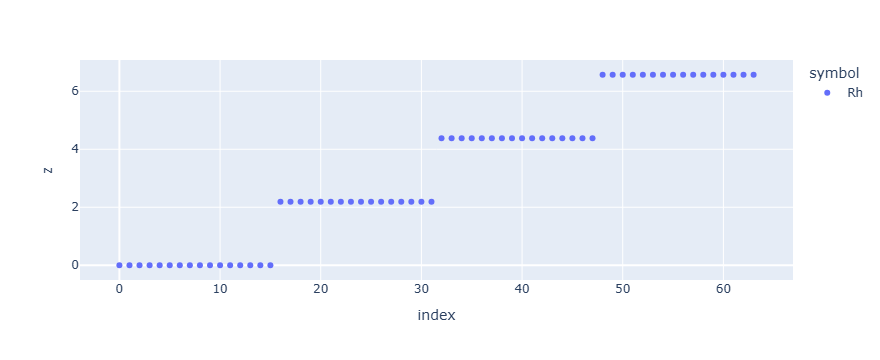

In [6]:
import plotly.express as px

# Check z_position of atoms
atoms = slab
df = pd.DataFrame({
    "x": atoms.positions[:, 0],
    "y": atoms.positions[:, 1],
    "z": atoms.positions[:, 2],
    "symbol": atoms.symbols,
})
display(df)

coord = "z"
df_sorted = df.sort_values(coord).reset_index().rename({"index": "atom_index"}, axis=1)
fig = px.scatter(df_sorted, x=df_sorted.index, y=coord, color="symbol", hover_data=["x", "y", "z", "atom_index"])
fig.show()

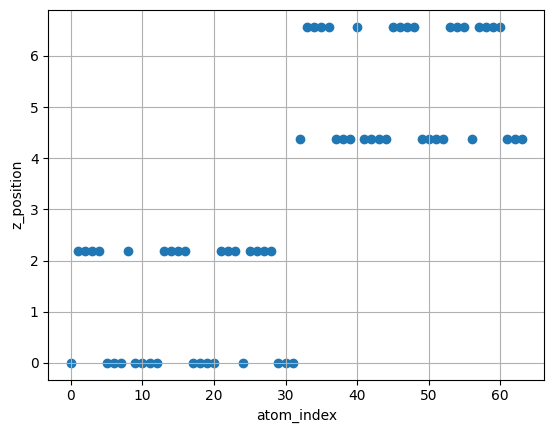

In [7]:
fig, ax = plt.subplots()
ax.scatter(df.index, df["z"])
ax.grid(True)
ax.set_xlabel("atom_index")
ax.set_ylabel("z_position")
plt.show(fig)

In [8]:
print("highest position (z) =", df["z"].max())

highest position (z) = 6.57014277664258


### 1-4 Structural optimization by fixing the lower layer of the slab structure

The [FixAtoms](https://wiki.fysik.dtu.dk/ase//ase/constraints.html#ase.constraints.FixAtoms) method
allows you to perform structural optimization while fixing the atoms in the lower layers of the slab structure. <br/>

Here we have fixed the atoms that below 1A, and thus, only the bottom layer is fixed.
The atomic positions of the surface atoms should be relaxed.

In [9]:
%%time
# Fix atoms under z=1A
c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] <= 1])
slab.set_constraint(c)
slab.calc = calculator

os.makedirs("output", exist_ok=True)
BFGS_opt = BFGS(slab, trajectory="output/slab_opt.traj")#, logfile=None)
BFGS_opt.run(fmax=0.005)

      Step     Time          Energy          fmax
BFGS:    0 14:51:11     -372.832192        0.168079
BFGS:    1 14:51:11     -372.841180        0.155755
BFGS:    2 14:51:11     -372.886189        0.137967
BFGS:    3 14:51:11     -372.891345        0.136545
BFGS:    4 14:51:11     -372.937758        0.070661
BFGS:    5 14:51:11     -372.939991        0.056810
BFGS:    6 14:51:11     -372.941786        0.023320
BFGS:    7 14:51:11     -372.942192        0.008791
BFGS:    8 14:51:12     -372.942233        0.001065
CPU times: user 85.3 ms, sys: 14.8 ms, total: 100 ms
Wall time: 665 ms


True

The actual optimization process shows that only the position of the top three layers is changed.

In [10]:
view_ngl(Trajectory("output/slab_opt.traj"), representations=["ball+stick"])

In [11]:
slabE = slab.get_potential_energy()
print(f"slab E = {slabE} eV")

slab E = -372.9422334793584 eV


In [12]:
# Save slab structure
os.makedirs("output/structures/", exist_ok=True)
write("output/structures/Slab_Rh_111.xyz", slab)

<a id="chap2"></a>

## 2. Put molecule on the slab and make initial and final states 
### 2-1 Load the molecule to be adsorbed and get the potential energy after structural optimization

This time, we will use [molecule module](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) of ase. <br/>
You can also read from cif file, sdf file, etc. in the same way as loading the bulk structure.

In [13]:
molec = molecule("NO")
# example to read sdf file
# molec = read("xxxxxx.sdf")

In [14]:
molec.calc = calculator
BFGS_opt = BFGS(molec, trajectory="output/molec_opt.traj", logfile=None)
BFGS_opt.run(fmax=0.005)
molecE = molec.get_potential_energy()
print(f"molecE =　{molecE} eV")

molecE =　-7.260690701708345 eV


In [15]:
view_ngl(Trajectory("output/molec_opt.traj"), representations=["ball+stick"])

### 2-2 Adsorption energy calculation

Let's create an adsorption structure.
Here we use the [add_adsorbate](https://wiki.fysik.dtu.dk/ase//ase/build/surface.html#ase.build.add_adsorbate) method to place the `molec` on top of the `slab`.

In [16]:
mol_on_slab = slab.copy()

# height: height of molecule from slab surface
# position: x,y position of molecule
# The molecule position can be modified later, and thus rough value is ok here.
add_adsorbate(mol_on_slab, molec, height=3, position=(8, 4))
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)

#### SurfaceEditor

The class `SurfaceEditor` is used to adjust the adsorption position of the molecule.

<Usage>

1. Use `SurfaceEditor(atoms).display()` to display the structure you want to edit.
2. Get the indices of the molecule you want to move with `atoms z>` button. The molecule is the atoms above the highest coordinate of the slab structure which we confirmed in 1-3. If set appropriately, only the index of the molecule will be included in the box below. 
3. Use XYZ+- of "move", "rotate" to change the position or the orientation of the molecule. <br/> Adjusting the ball size will make the adsorption site easier to be seen.
4. Click the "Run mini opt" button to perform the structural optimization using BFGS for a given number of steps.

In this tutorial, we will create an adsorption structure based on the following paper.

"First-Principles Microkinetic Analysis of NO + CO Reactions on Rh(111) Surface toward Understanding NOx Reduction Pathways"

 - https://pubs.acs.org/doi/10.1021/acs.jpcc.8b05906

In this example, The hcp adsorption structure can be created by pressing "X-" three times, "Y+" once, and "Z-" four times. <br/>
See the figure below for the FCC and HCP sites of adsorption.

<blockquote>
<figure>
<img src="https://www.researchgate.net/profile/Monica-Pozzo/publication/5521348/figure/fig1/AS:281313635520514@1444081805255/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen.png"/>
<figcaption>(Colour) Possible adsorption sites (top, bridge, hollow-hcp and hollow-fcc) for hydrogen (dark red) on the Mg(0001) surface (light blue).<br/>
from <a href="https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348">https://www.researchgate.net/figure/Colour-Possible-adsorption-sites-top-bridge-hollow-hcp-and-hollow-fcc-for-hydrogen_fig1_5521348</a>
</figcaption>
</figure>
</blockquote>

In [17]:
# calculator must be set when SurfaceEditor is used
mol_on_slab.calc = calculator

In [18]:
from pfcc_extras.visualize.surface_editor import SurfaceEditor


se = SurfaceEditor(mol_on_slab)
se.display()

In [19]:
c = FixAtoms(indices=[atom.index for atom in mol_on_slab if atom.position[2] <= 1])
mol_on_slab.set_constraint(c)
BFGS_opt = BFGS(mol_on_slab, logfile=None)
BFGS_opt.run(fmax=0.005)
mol_on_slabE = mol_on_slab.get_potential_energy()
print(f"mol_on_slabE = {mol_on_slabE} eV")

mol_on_slabE = -382.5945561938515 eV


In [20]:
os.makedirs("output/ad_structures/",  exist_ok=True)
write("output/ad_structures/mol_on_Rh(111).cif", mol_on_slab)

/home/jovyan/.py39/lib/python3.9/site-packages/ase/io/cif.py:834: UserWarning:

Occupancies present but no occupancy info for "{symbol}"



### 2-3 Adsorption energy

The adsorption energy can be obtained by calculating the energy difference of the slab and the molecule when they existed separately and when they were combined.

The value in the above paper is 1.79 eV. The discrepancy is likely due to the fact that the paper uses the RPBE functional, while the PFP uses the PBE functional.

In [21]:
# Calculate adsorption energy
adsorpE = slabE + molecE - mol_on_slabE
print(f"Adsorption Energy: {adsorpE} eV")

Adsorption Energy: 2.3916320127847257 eV


### 2-4 List adsorption structures

In [22]:
ad_st_path = "output/ad_structures/*"
ad_stru_list = [(filepath, read(filepath)) for filepath in glob.glob(ad_st_path)]

In [23]:
pd.DataFrame(ad_stru_list)

0  \
0  output/ad_structures/mol_on_Rh(111).cif   

                                                   1  
0  (Atom('Rh', [1.0070710572213604, 0.99591751311...

In [24]:
No = 0
view_ngl(ad_stru_list[No][1] , representations=["ball+stick"])

### 2-5 Create IS structure

Here we will create the IS and FS structures to run the NEB. <br/>
You may skip to [3. NEB calculation](#chap3) as we will use the structures we have created in advance.

In [25]:
filepath, atoms = ad_stru_list[No]
print(filepath)
IS = atoms.copy()

output/ad_structures/mol_on_Rh(111).cif


Let's create the following structure adsorbed on the FCC site.

<figure>
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00000.png" width="150"/>
  <figcaption>
      Initial state: structure with NO adsorbed on FCC site
  </figcaption>
</figure>

In [26]:
IS.calc = calculator
SurfaceEditor(IS).display()

In [27]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.05)
IS.get_potential_energy()

-382.59455319483493

### 2-6 Create FS structure

Create the final state in the same way. <br/>
In this tutorial, we use the structure that the N and O are moved and adsorbed to the HCP site.

<figure>
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00001.png" width="150"/>
  <figcaption>
      Final state: Structure in which N and O are each adsorbed on HCP sites.
  </figcaption>
</figure>

In [28]:
FS = IS.copy()

In [29]:
FS.calc = calculator
SurfaceEditor(FS).display()

In [30]:
FS.calc = calculator
c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
FS.get_potential_energy()

-382.59455319483493

Save IS, FS structures

In [31]:
filepath = Path(filepath).stem
# filepath = Path(ad_stru_list[No][0]).stem
os.makedirs(filepath, exist_ok=True)
write(filepath+"/IS.cif", IS)
write(filepath+"/FS.cif", FS)

<a id="chap3"></a>

## 3. NEB calculation

### 3-1 NEB calculation

This time, we will use the initial and final state files created in advance to perform the reaction path search. <br/>
The example [matlantis-contrib/matlantis_contrib_examples/NEB_Solid_catalyst](https://github.com/matlantis-pfcc/matlantis-contrib/tree/main/ matlantis_contrib_examples/NEB_Solid_catalyst) shows the NEB calculation for the reaction NO(fcc) -> N(fcc) + O(fcc).<br/>
In this Tutorial, we will try the NEB calculation for the reaction NO(fcc) -> N(hcp) + O(hcp).

In [32]:
!cp -r "../input/NO_dissociation_NO(fcc)_N(fcc)_O(fcc)" .
!cp -r "../input/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)" .

In [33]:
# filepath = "NO_dissociation_NO(fcc)_N(fcc)_O(fcc)"
filepath = "NO_dissociation_NO(fcc)_N(hcp)_O(hcp)"

The created IS, FS structures look like follows.

In [34]:
IS = read(filepath+"/IS.cif")
FS = read(filepath+"/FS.cif")

view_ngl([IS, FS], representations=["ball+stick"], replace_structure=True)

In [35]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    [IS, FS],
    gif_filepath=f"./output/{filepath}/NEB_IS_FS.gif",
    pngdir=f"./output/{filepath}/png",
    rotation="-60x, 30y, 15z",
    clean=False,
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.9s finished


<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:10px">
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00000.png"/>
  <figcaption>
      Initial State
  </figcaption>
</figure>
<figure style="width:30%;float:left;margin:10px">
　　　　<img src="./output/NO_dissociation_NO(fcc)_N(hcp)_O(hcp)/png/00001.png"/>
  <figcaption>
      Final State
  </figcaption>
</figure>
</div>

<figure>
</figure>

In [36]:
c = FixAtoms(indices=[atom.index for atom in IS if atom.position[2] <= 1])
IS.calc = calculator
IS.set_constraint(c)
BFGS_opt = BFGS(IS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"IS {IS.get_potential_energy()} eV")

c = FixAtoms(indices=[atom.index for atom in FS if atom.position[2] <= 1])
FS.calc = calculator
FS.set_constraint(c)
BFGS_opt = BFGS(FS, logfile=None)
BFGS_opt.run(fmax=0.005)
print(f"FS {FS.get_potential_energy()} eV")

IS -382.51640121618146 eV
FS -383.47450991794597 eV


In [37]:
beads = 21

NEB is faster with `parallel = True` and `allowed_shared_calculator=False`.

In [38]:
b0 = IS.copy()
b1 = FS.copy()
configs = [b0.copy() for i in range(beads-1)] + [b1.copy()]
for config in configs:
    # Calculator must be set separately with NEB parallel=True, allowed_shared_calculator=False.
    estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v3.0.0")
    calculator = ASECalculator(estimator)
    config.calc = calculator

First, linear interpolation of `configs`, which are candidate reaction pathways, is performed using NEB `interpolate` method.

In [39]:
# k： spring constant. It was stable to when reduced to 0.05
neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)   
neb.interpolate()

/tmp/ipykernel_38592/1063292405.py:2: FutureWarning:

Please import NEB from ase.mep, not ase.neb.



Check reaction path candidate after linear interpolation

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   14.4s finished


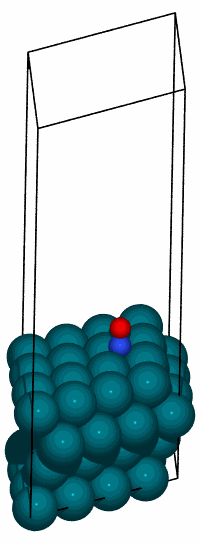

In [40]:
traj_to_gif(
    configs,
    gif_filepath=f"output/{filepath}/NEB_interpolate.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"output/{filepath}/NEB_interpolate.gif")

In [41]:
view_ngl(configs, representations=["ball+stick"], replace_structure=True)

NEB optimization is performed.

It is recommended that fmax is 0.05 or less. 
If fmax is too small, it will take a long time to converge.
We use a loose convergence condition (e.g., 0.2) in the first NEB calculation. If a reasonable reaction path is obtained, you can make the convergence condition tighter for a more stable calculation.
If an abnormal reaction path is obtained with a loose convergence condition, please check the IS and FS structures.

The calculation time is around ten minutes. Please wait. 
Refer to `neb_log.txt` if you want to check the progress.

In [42]:
%%time
steps=2000

relax = FIRE(neb, trajectory=None, logfile=filepath+"/neb_log.txt")

# fmax<0.05 recommended. It takes time when it is smaller.
# 1st NEB calculation can be executed with loose condition (Ex. fmax=0.2),
# and check whether reaction path is reasonable or not.
# If it is reasonable, run 2nd NEB with tight fmax condition.
# If the reaction path is abnormal, check IS, FS structure.
relax.run(fmax=0.1, steps=steps)

CPU times: user 6.69 s, sys: 1.23 s, total: 7.92 s
Wall time: 11.8 s


True

After the first loose convergence, check for anomalies in the reaction path.

In [43]:
view_ngl(configs, representations=["ball+stick"], replace_structure=True)

After confirming that the reaction path is OK, a second NEB calculation is performed with tighter convergence conditions.

In [44]:
# additional calculation
steps = 10000
relax.run(fmax=0.02, steps=steps)              

True

In [45]:
write(filepath+"/NEB_images.xyz", configs)

<a id="chap4"></a>

## 4. Check NEB calculation results

First, let's visualize the results in several ways. Here, we will create a gif file from png figures.

In [46]:
configs = read(filepath+"/NEB_images.xyz", index=":")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:   13.6s finished


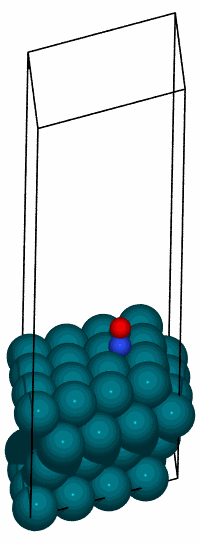

In [47]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    configs,
    gif_filepath=f"output/{filepath}/NEB_result.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"output/{filepath}/NEB_result.gif")

Obtain the index of TS structure. <br/>
Looking at the energy and force, you can see that the system reaches the [saddle point](https://en.wikipedia.org/wiki/Saddle_point) (see below) at index=12 where the energy is maximum and the force is near 0.

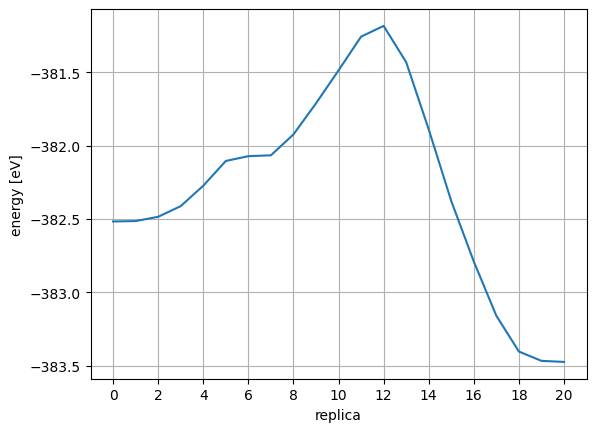

In [48]:
for config in configs:
    config.calc = calculator
energies = [config.get_total_energy() for config in configs]

plt.plot(range(len(energies)),energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.xticks(np.arange(0, len(energies), 2))
plt.grid(True)
plt.show()

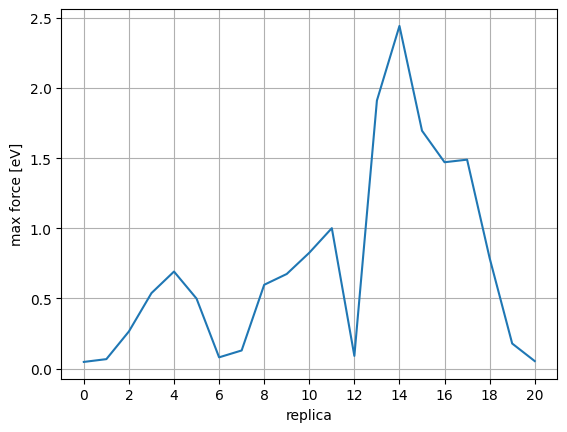

In [49]:
def calc_max_force(atoms):
    return ((atoms.get_forces() ** 2).sum(axis=1).max()) ** 0.5

mforces = [calc_max_force(config) for config in configs]
plt.plot(range(len(mforces)), mforces)
plt.xlabel("replica")
plt.ylabel("max force [eV]")
plt.xticks(np.arange(0, len(mforces), 2))
plt.grid(True)
plt.show()

It should be confirmed in the max force plot that the force is close to 0 at the following three points:

 - Starting state (index=0)
 - Transition state (index=12)
 - End state (index=20)

However, we use `FixAtoms` to fix some atoms in this calculation. The points in the plot will not be 0 if the force of the fixed atoms is large.

The activation energy can be calculated by looking at the energy difference between the initial structure `index=0` and the transition state `index=12`.

In [50]:
ts_index = 12
actE = energies[ts_index] - energies[0]
deltaE = energies[ts_index] - energies[-1]
print(f"actE {actE} eV, deltaE {deltaE} eV")

actE 1.3338447542966492 eV, deltaE 2.291962324442352 eV


### Rerun NEB

If the intermediate images obtained from NEB calculation contain a structure that is more suitable for the initial state and final state, please extract the structure and rerun the NEB using it as IS or FS.

<a id="chap5"></a>

## 5. Structural optimization of the transition state structure by Sella

The TS structure obtained in the NEB above is not the exact [saddle point](https://en.wikipedia.org/wiki/Saddle_point). (*)
Here, the TS structure is optimized using a library called [sella](https://github.com/zadorlab/sella).

(*) What is **saddle point**:

The initial and final states are structures at local minima.
Since the energy increases when a small displacement occurs in any direction, all components should be positive when the Hessian is diagonalized, as explained in section 4-1 Vibration (the second derivative is a positive definite matrix, and the intuitive explanation is that the energy surface looks like $y=ax^2 (a>0)$ for any direction.).

In contrast, a transition state is one in which only one diagonal component of the Hessian is negative and the remaining components are positive (except 5 or 6 translational, rotational invariant direction). <br/>
The energy goes down only in the direction connecting the initial state and the final state (in the shape of $y=ax^2 (a<0)$ at the local potential energy surface), and the energy increases in the other directions. 
Such a point is called a saddle point.

See also the following figure used in the previous section.

<figure style="width: 480px">
　　　　<img src="../assets/neb-small-720.png"/>
</figure>

To calculate the exact activation energy, it is necessary to find the exact transition state point.

In [51]:
!pip install sella

Looking in indexes: https://pypi.org/simple, http://pypi.artifact.svc:8080/simple

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [52]:
TSNo = 12
TS = configs[TSNo].copy()
c = FixAtoms(indices=[atom.index for atom in TS if atom.position[2] <= 1])
TS.set_constraint(c)

In [53]:
from sella import Sella, Constraints


TS.calc = calculator
# TS optimization with Sella
TSopt = Sella(TS)
%time TSopt.run(fmax=0.05)
potentialenergy = TS.get_potential_energy()
print (TS.get_potential_energy(), TS.get_forces().max())

     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 14:52:29     -381.182530       0.0060       0.0000       0.1000       1.0000
CPU times: user 52.4 ms, sys: 3.17 ms, total: 55.6 ms
Wall time: 129 ms
-381.18252971221847 0.001485462227719836


/home/jovyan/.py39/lib/python3.9/site-packages/ase/optimize/optimize.py:372: FutureWarning:

force_consistent keyword is deprecated and will be ignored.  This will raise an error in future versions of ASE.



In [54]:
write(filepath + "/TS_opt.cif", TS)

In [55]:
# Compare before and after TS optimization

view_ngl([configs[TSNo], TS], representations=["ball+stick"], replace_structure=True)

<a id="chap6"></a>

## 6. Vibration analysis of transition states

The transition state must be a saddle point where only one second derivative is negative and the others are positive. <br/>
If more than one value is negative, it suggests the existence of the other transition states with lower activation energies than that point.

We will perform a vibrational analysis to make sure that we obtain the correct transition state.

In [56]:
# Vibration analysis is executed with atoms `z_pos >= zz`

z_pos = pd.DataFrame({
    "z": TS.positions[:, 2],
    "symbol": TS.symbols,
})
vibatoms = z_pos[z_pos["z"] >= 7.0].index
vibatoms

Index([64, 65], dtype='int64')

In [57]:
# Vibration analysis

vibpath = filepath + "/TS_vib/vib"
os.makedirs(vibpath, exist_ok=True)
# Vibration analysis is executed with only specified atoms `indices=vibatoms`
vib = Vibrations(TS, name=vibpath, indices=vibatoms)
vib.run()
vib_energies = vib.get_energies()

thermo = IdealGasThermo(vib_energies=vib_energies,
                        potentialenergy=potentialenergy,
                        atoms=TS,
                        geometry='linear',     #'monatomic', 'linear', or 'nonlinear'
                        symmetrynumber=2, spin=0, natoms=len(vibatoms),
                        ignore_imag_modes=True)
G = thermo.get_gibbs_energy(temperature=298.15, pressure=101325.)

Enthalpy components at T = 298.15 K:
E_pot               -381.183 eV
E_ZPE                  0.000 eV
Cv_trans (0->T)        0.039 eV
Cv_rot (0->T)          0.026 eV
Cv_vib (0->T)          0.000 eV
(C_v -> C_p)           0.026 eV
-------------------------------
H                   -381.093 eV

Entropy components at T = 298.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022653 eV/K        0.675 eV
S_rot              0.0012596 eV/K        0.376 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0000000 eV/K        0.000 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0035238 eV/K        1.051 eV

Free energy components at T = 298.15 K and P = 101325.0 Pa:
    H       -381.093 eV
 -T*S         -1.051 eV
-----------------------
    G       -382.143 eV


/home/jovyan/.py39/lib/python3.9/site-packages/ase/thermochemistry.py:820: UserWarning:

1 imag modes removed



In [58]:
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   66.6i    536.8i
  1   21.2     170.6
  2   35.7     288.0
  3   51.3     413.7
  4   60.4     487.5
  5   64.6     520.7
---------------------
Zero-point energy: 0.117 eV


We have confirmed that only **one negative frequency (imaginary wavenumber)** has been obtained.

In [59]:
vib.summary(log=filepath+"/vib_summary.txt")

Output `traj` file for each vibration mode for visualization.

In [60]:
vib.write_mode(n=0, kT=300*kB, nimages=30)
vib.clean()

13

Look summary table and enter the vibration mode number you want to display.

In [61]:
n = 0
vib_traj = Trajectory(vibpath + f".{n}.traj")

view_ngl(vib_traj, representations=["ball+stick"])

In [62]:
write(filepath + "/vib_traj.xyz", vib_traj)

In [63]:
vib_traj = read(filepath + "/vib_traj.xyz", index=":")

In [64]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    vib_traj,
    gif_filepath=f"output/{filepath}/vib.gif",
    rotation="-60x, 30y, 15z"
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   19.9s finished


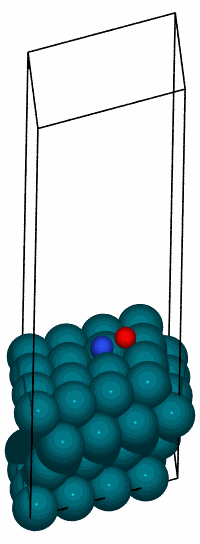

In [65]:
ImageWidget(f"output/{filepath}/vib.gif")

Check to see if it is an imaginary oscillation. The middle (and 0) is TS.

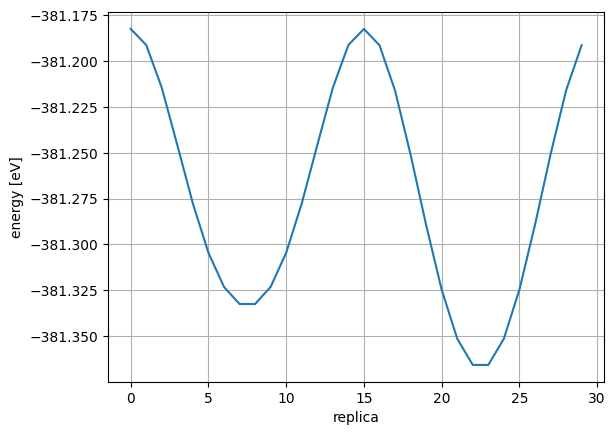

In [66]:
vib_energies = []
for i in vib_traj:
    i.calc = calculator
    vib_energies.append(i.get_potential_energy())
plt.plot(range(len(vib_energies)), vib_energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.grid(True)
plt.show()